# Crime Hotspot Forecasting

This notebook uses the Bristol crime dataset to build a model for predicting future crime hotspots. A heatmap visualization of crime density across Bristol is generated using latitude and longitude data. The model aims to support public safety initiatives by identifying areas with higher crime risk.

In [10]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import networkx as nx
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc

In [11]:
# Load the Bristol crime dataset
crime_data = pd.read_csv('Data/bristol_crime_ml_ready.csv')
crime_data['month_num'] = pd.to_datetime(crime_data['month_num'])
crime_data.head()

,category,location_type,location,context,outcome_status,persistent_id,id,location_subtype,month,lat,lng,street_name,year,month_num,category_code
0,anti-social-behaviour,Force,"{'latitude': '51.447531', 'street': {'id': 227...",NaN,NaN,NaN,106880411,NaN,2022-12,51.447531,-2.590662,On or near Redcliff Hill,2022,1970-01-01 00:00:00.000000012,0
1,anti-social-behaviour,Force,"{'latitude': '51.456844', 'street': {'id': 227...",NaN,NaN,NaN,106879221,NaN,2022-12,51.456844,-2.594626,On or near Rupert Street,2022,1970-01-01 00:00:00.000000012,0
2,anti-social-behaviour,Force,"{'latitude': '51.453030', 'street': {'id': 227...",NaN,NaN,NaN,106879167,NaN,2022-12,51.453030,-2.593194,On or near,2022,1970-01-01 00:00:00.000000012,0
3,anti-social-behaviour,Force,"{'latitude': '51.456677', 'street': {'id': 227...",NaN,NaN,NaN,106880442,NaN,2022-12,51.456677,-2.592162,On or near,2022,1970-01-01 00:00:00.000000012,0
4,anti-social-behaviour,Force,"{'latitude': '51.458279', 'street': {'id': 227...",NaN,NaN,NaN,106880357,NaN,2022-12,51.458279,-2.584727,On or near,2022,1970-01-01 00:00:00.000000012,0


## Data Preparation
Select relevant columns (latitude, longitude) and remove missing values.

In [12]:
# Dynamically find the correct columns for latitude, longitude, date, crime category, and outcome
print('crime_data columns:', crime_data.columns.tolist())
possible_lat = [col for col in crime_data.columns if 'lat' in col.lower()]
possible_lon = [col for col in crime_data.columns if 'lon' in col.lower() or 'lng' in col.lower()]
possible_date = [col for col in crime_data.columns if 'date' in col.lower() or 'month' in col.lower()]
possible_cat = [col for col in crime_data.columns if 'cat' in col.lower() or 'type' in col.lower()]
possible_outcome = [col for col in crime_data.columns if 'outcome' in col.lower() or 'result' in col.lower() or 'resolved' in col.lower()]
print('Possible latitude columns:', possible_lat)
print('Possible longitude columns:', possible_lon)
print('Possible date columns:', possible_date)
print('Possible category columns:', possible_cat)
print('Possible outcome columns:', possible_outcome)
# Only use columns that exist
features = []
if possible_lat: features.append(possible_lat[0])
if possible_lon: features.append(possible_lon[0])
if possible_date: features.append(possible_date[0])
if possible_cat: features.append(possible_cat[0])
if possible_outcome:
    df = crime_data.dropna(subset=features + [possible_outcome[0]])
    print('Using columns for dropna:', features + [possible_outcome[0]])
else:
    print('No outcome column found!')
coords = df[[possible_lat[0], possible_lon[0]]].dropna()
coords.columns = ['Latitude', 'Longitude']
coords.head()

crime_data columns: ['category', 'location_type', 'location', 'context', 'outcome_status', 'persistent_id', 'id', 'location_subtype', 'month', 'lat', 'lng', 'street_name', 'year', 'month_num', 'category_code']
Possible latitude columns: ['lat']
Possible longitude columns: ['lng']
Possible date columns: ['month', 'month_num']
Possible category columns: ['category', 'location_type', 'location', 'location_subtype', 'category_code']
Possible outcome columns: ['outcome_status']
Using columns for dropna: ['lat', 'lng', 'month', 'category', 'outcome_status']


,Latitude,Longitude
182,51.461429,-2.601839
183,51.453567,-2.586596
184,51.456619,-2.598322
185,51.449712,-2.580617
186,51.453850,-2.592874


## Crime Hotspot Modeling
Apply KMeans clustering to identify crime hotspots.

In [13]:
# Fit KMeans to find hotspots
kmeans = KMeans(n_clusters=10, random_state=42)
coords['Cluster'] = kmeans.fit_predict(coords)
centers = kmeans.cluster_centers_
coords.head()

,Latitude,Longitude,Cluster
182,51.461429,-2.601839,8
183,51.453567,-2.586596,1
184,51.456619,-2.598322,5
185,51.449712,-2.580617,6
186,51.453850,-2.592874,5


## Crime Density Heatmap
Visualize the density of crime incidents and identified hotspots.

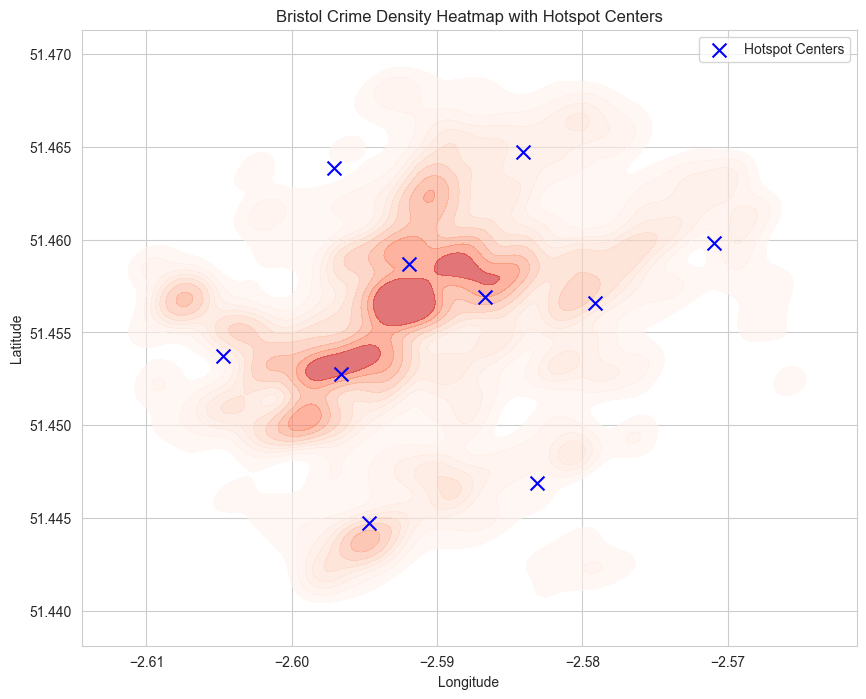

In [130]:
# Plot heatmap and cluster centers
plt.figure(figsize=(10, 8))
sns.kdeplot(x=coords['Longitude'], y=coords['Latitude'], cmap='Reds', fill=True, thresh=0.05, alpha=0.6)
plt.scatter(centers[:, 1], centers[:, 0], c='blue', s=100, marker='x', label='Hotspot Centers')
plt.title('Bristol Crime Density Heatmap with Hotspot Centers')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

### Model Relevance

Identifying and forecasting crime hotspots helps law enforcement and city planners allocate resources more effectively, improving public safety and community well-being.

## Crime Frequency by Type

This bar chart shows the frequency of each crime type, helping quickly identify the most frequently occurring crimes.

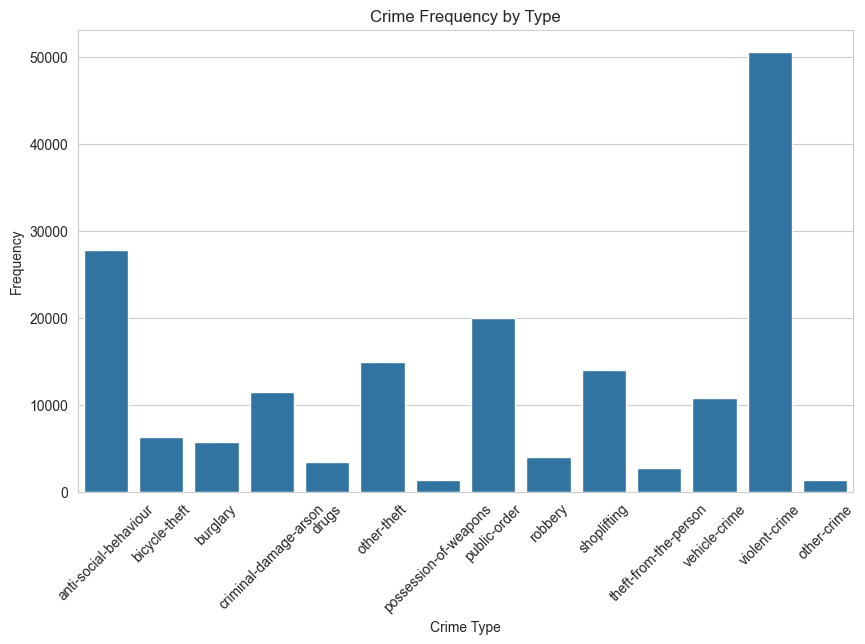

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting crime frequency by type
plt.figure(figsize=(10,6))
sns.countplot(x='category', data=data)
plt.title('Crime Frequency by Type')
plt.xlabel('Crime Type')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

## Crime Frequency by Year

This grouped bar chart displays the top 15 crime categories distributed by year, using distinct colors for easy comparison. It helps identify yearly trends and fluctuations in different types of crimes.

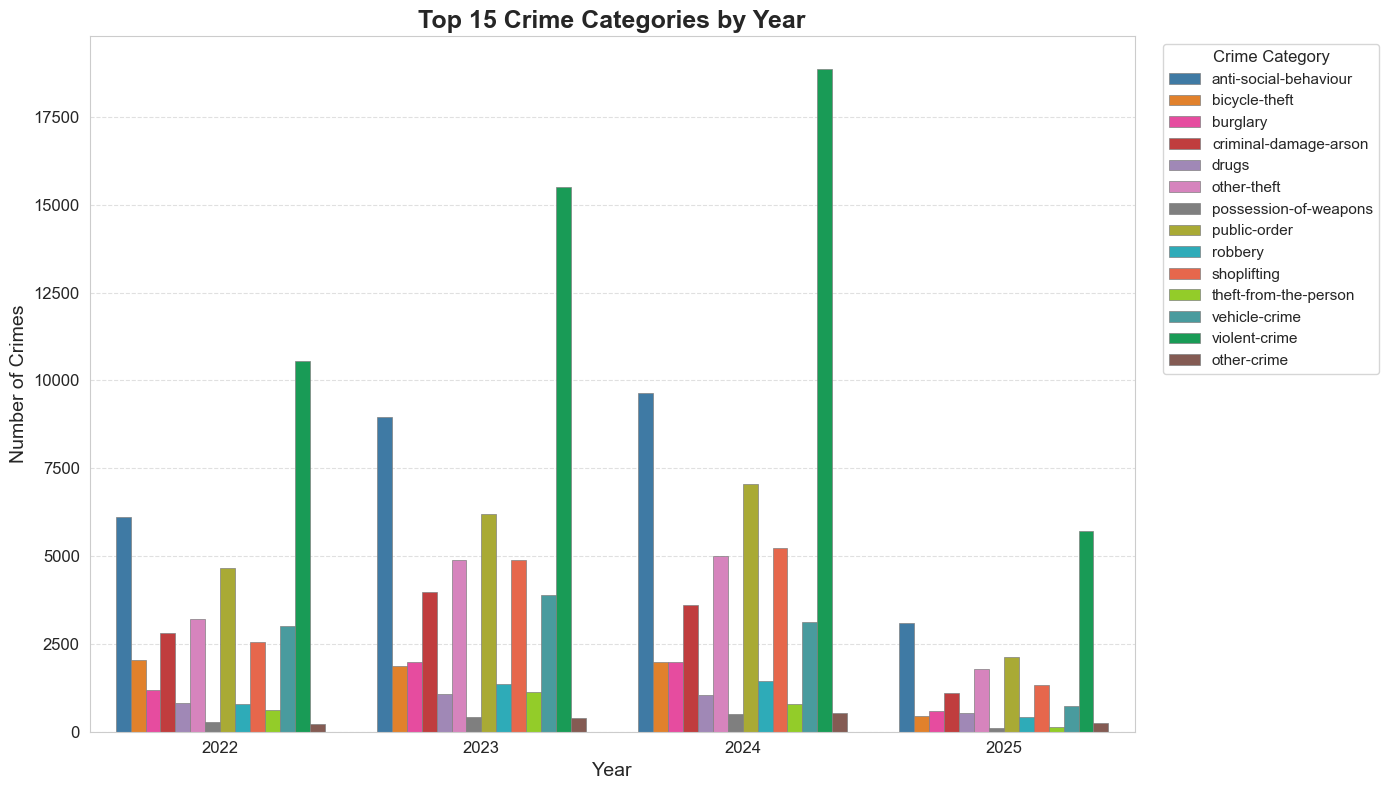

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Get top 15 categories
top_15_categories = data['category'].value_counts().nlargest(15).index.tolist()

# Step 2: Filter data
filtered_data = data[data['category'].isin(top_15_categories)]

# Step 3: Use a set of 15 very distinct, professional hex colors
color_list = [
    "#2e7db5", "#ff7f0e", "#ff33a1", "#d62728", "#a080be",
    "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
    "#ff5733", "#9BE70E62", "#3BA8AC", "#04B0548F", "#8a07fd"
]

# Step 4: Map sorted categories to those colors (to avoid random assignment)
top_15_categories_sorted = sorted(top_15_categories)
custom_palette = dict(zip(top_15_categories_sorted, color_list))

# Step 5: Plot
plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")

sns.countplot(
    x='year',
    hue='category',
    data=filtered_data,
    palette=custom_palette,
    dodge=True,
    edgecolor='gray',
    linewidth=0.5
)

plt.title('Top 15 Crime Categories by Year', fontsize=18, fontweight='bold')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Crimes', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Crime Category', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=11, title_fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


## Top 20 Streets with Most Violent Crimes 

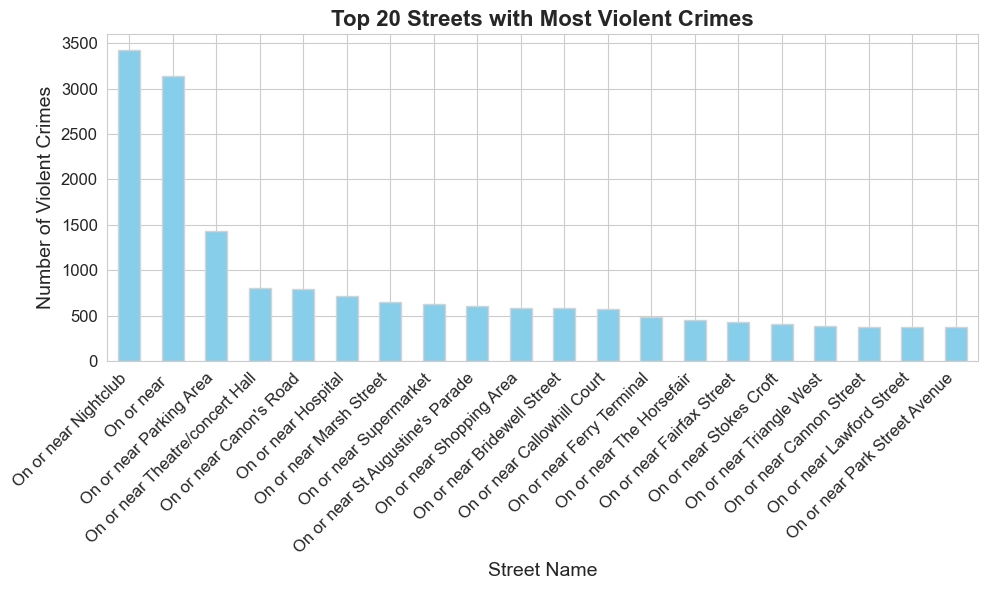

In [95]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'Data/bristol_crime_ml_ready.csv'
data = pd.read_csv(file_path)

# Create the binary target variable (1 for violent crime, 0 for non-violent crime)
violent_crime_categories = ['violent-crime', 'other-crimes']
data['violent_crime'] = data['category'].apply(
    lambda x: 1 if any(violent in str(x).lower() for violent in violent_crime_categories) else 0
)

# 👉 Don't modify street names — use them as they are
# Count the number of violent crimes per original street name
street_violent_crimes = data[data['violent_crime'] == 1]['street_name'].value_counts().head(20)

# Plot the distribution of violent crimes across streets
plt.figure(figsize=(10, 6))
street_violent_crimes.plot(kind='bar', color='skyblue', edgecolor='lightgray')

plt.title('Top 20 Streets with Most Violent Crimes', fontsize=16, fontweight='bold')
plt.xlabel('Street Name', fontsize=14)
plt.ylabel('Number of Violent Crimes', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Read the Excel file
file_path = 'Data/bristol_crime_ml_ready.csv'
data = pd.read_csv(file_path)

# Display the first few rows
#print(data.head())


# Step 1: Create the binary target variable (1 for violent crime, 0 for other crime)
# violent_crime_categories = ['violent-crime', 'other-crime'] # The original code included 'other-crime' in violent crime, which might be incorrect
violent_crime_categories = ['violent-crime', 'other-violent-crime', 'violence and sexual offences']

# Apply the logic to create a binary target variable
data['violent_crime'] = data['category'].apply(lambda x: 1 if any(violent in str(x).lower() for violent in violent_crime_categories) else 0)

# Step 2: Prepare the features (lat, lng, month_num, year)
# We will use 'lat', 'lng', 'month_num', and 'year' as the features
# Drop any rows with missing values in these columns
X = data[['lat', 'lng', 'month_num', 'year']].dropna()

# The target variable: violent crime (binary)
y = data.loc[X.index, 'violent_crime']

# Step 3: Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Initialize and train the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 5: Predict on the test set
y_pred = model.predict(X_test)

# Step 6: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Print results
print(f"Accuracy: {accuracy}")
print("Classification Report:\n", report)





Accuracy: 0.7638029782359679
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.89      0.84     24888
           1       0.62      0.46      0.53     10032

    accuracy                           0.76     34920
   macro avg       0.71      0.67      0.69     34920
weighted avg       0.75      0.76      0.75     34920



## Prediction

In [104]:
# Step 1: Setup prediction time frame
future_year = 2026
future_months = range(1, 13)

# Step 2: Use average lat/lng from existing data (calculate once)
avg_lat = data['lat'].mean()
avg_lng = data['lng'].mean()

# Step 3: Build future data using list comprehension
future_data = [[avg_lat, avg_lng, month, future_year] for month in future_months]

# Step 4: Create DataFrame with consistent feature names
features = ['lat', 'lng', 'month_num', 'year']
future_df = pd.DataFrame(future_data, columns=features)

# Step 5: Predict with trained model
future_df['violent_crime_pred'] = model.predict(future_df)

# Step 6: Add human-readable labels
#future_df['prediction_label'] = future_df['violent_crime_pred'].map({
 #   0: 'Non-Violent Crime',
 #   1: 'Violent Crime'
##})

# Step 7: Display results
print(future_df)


          lat       lng  month_num  year  violent_crime_pred
0   51.455713 -2.590232          1  2026                   0
1   51.455713 -2.590232          2  2026                   0
2   51.455713 -2.590232          3  2026                   0
3   51.455713 -2.590232          4  2026                   0
4   51.455713 -2.590232          5  2026                   0
5   51.455713 -2.590232          6  2026                   0
6   51.455713 -2.590232          7  2026                   0
7   51.455713 -2.590232          8  2026                   0
8   51.455713 -2.590232          9  2026                   0
9   51.455713 -2.590232         10  2026                   0
10  51.455713 -2.590232         11  2026                   0
11  51.455713 -2.590232         12  2026                   0


# Weather-Influenced Crime Prediction

This section merges the Bristol crime and weather datasets, then trains a classification model to predict crime categories based on weather features (temperature, precipitation, windspeed). A confusion matrix is included to visualize model performance, along with an explanation of how weather impacts crime.

In [122]:
import pandas as pd


# Step 1: Load crime + weather merged dataset
crime_data = pd.read_csv('Data/bristol_crime_ml_ready.csv')
weather = pd.read_csv('Data/bristol_weather_2010_2025.csv')

# Step 2: Ensure date columns are datetime
crime_data['month'] = pd.to_datetime(crime_data['month'])
weather['date'] = pd.to_datetime(weather['date'])

# Step 3: Merge datasets on date
merged = pd.merge(crime_data, weather, left_on='month', right_on='date', how='inner')

# Step 4: Drop rows with missing data
merged = merged.dropna(subset=['temperature_max', 'precipitation_sum', 'windspeed_max', 'category'])

# Step 5: Get top 5 crime categories
top_5 = merged['category'].value_counts().nlargest(5).index
filtered = merged[merged['category'].isin(top_5)]

# Step 6: Ensure 'month' is datetime (again, for safety)
filtered['month'] = pd.to_datetime(filtered['month'])

# Step 7: Group by month and crime category
monthly = (
    filtered
    .groupby(filtered['month'].dt.to_period('M'))['category']
    .value_counts()
    .unstack()
    .fillna(0)
)

print(monthly.head())

category  anti-social-behaviour  other-theft  public-order  shoplifting  \
month                                                                     
2022-05                     696          471           549          285   
2022-06                     762          354           615          288   
2022-07                     732          408           702          321   
2022-08                     951          366           708          360   
2022-09                     810          357           558          357   

category  violent-crime  
month                    
2022-05            1383  
2022-06            1260  
2022-07            1524  
2022-08            1332  
2022-09            1272  


## Monthly Crime Trend using weather data 

<Figure size 1400x600 with 0 Axes>

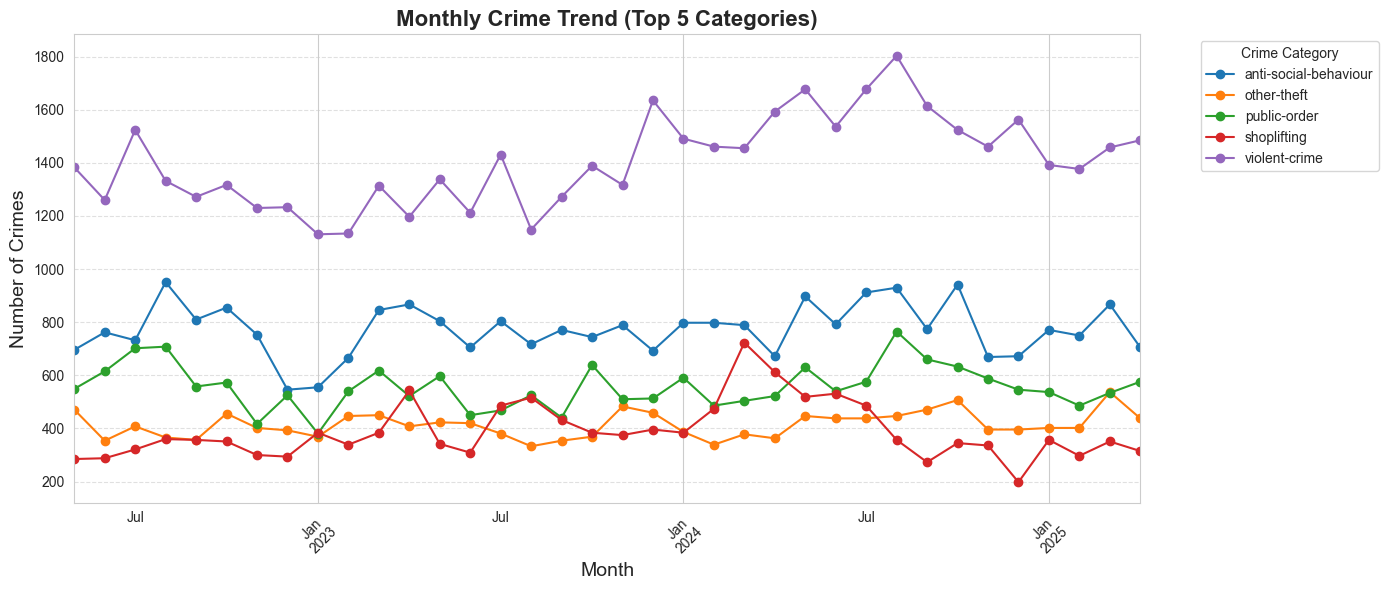

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



# Step 8: Plot the monthly trend
monthly.index = monthly.index.to_timestamp()  # convert PeriodIndex to datetime

plt.figure(figsize=(14, 6))
sns.set_style("whitegrid")

monthly.plot(marker='o', figsize=(14, 6))

plt.title("Monthly Crime Trend (Top 5 Categories)", fontsize=16, fontweight='bold')
plt.xlabel("Month", fontsize=14)
plt.ylabel("Number of Crimes", fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Crime Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

# Optional: Save the plot as an image
# plt.savefig("monthly_crime_trends.png", dpi=300)

plt.show()


it shows in the winter season the crime goes down ansd in summer the crimes goes up.

## Model Training and Confusion Matrix
Train a Random Forest classifier to predict crime category from weather features.

Accuracy: 0.5503

Classification Report:
                        precision    recall  f1-score   support

anti-social-behaviour       0.59      0.57      0.58      5561
          other-theft       0.41      0.56      0.47      2978
         public-order       0.42      0.46      0.44      4005
          shoplifting       0.46      0.85      0.59      2801
        violent-crime       0.77      0.49      0.60     10127

             accuracy                           0.55     25472
            macro avg       0.53      0.58      0.54     25472
         weighted avg       0.60      0.55      0.55     25472



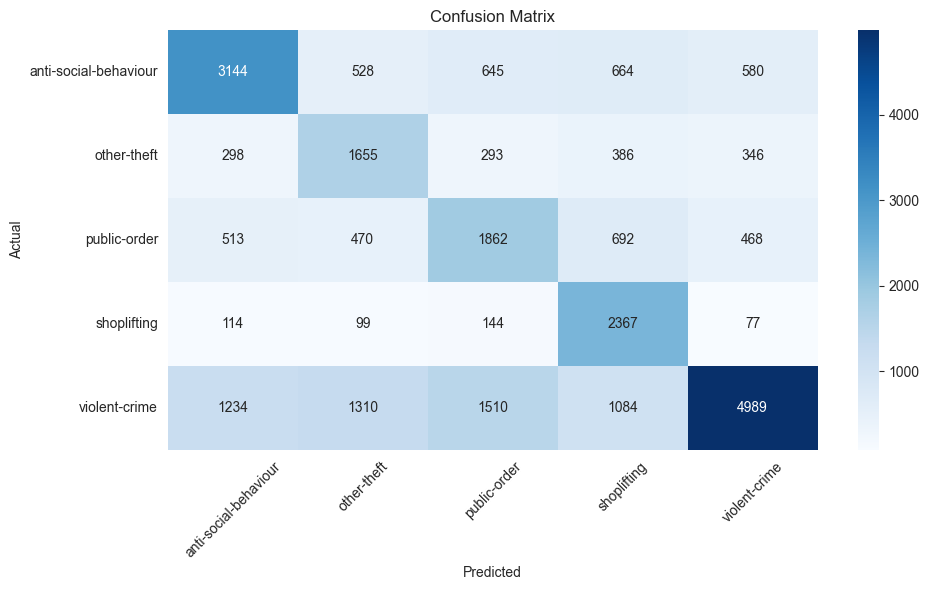

In [127]:
# Full code: Load data, preprocess, train model, evaluate

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load crime and weather datasets
crime_data = pd.read_csv('Data/bristol_crime_ml_ready.csv')
weather = pd.read_csv('Data/bristol_weather_2010_2025.csv')

# Step 2: Ensure date columns are datetime
crime_data['month'] = pd.to_datetime(crime_data['month'])
weather['date'] = pd.to_datetime(weather['date'])

# Step 3: Merge datasets on date
merged = pd.merge(crime_data, weather, left_on='month', right_on='date', how='inner')

# Step 4: Drop rows with missing data
merged = merged.dropna(subset=['temperature_max', 'precipitation_sum', 'windspeed_max', 'category'])

# Step 5: Get top 5 most frequent crime categories
top_5 = merged['category'].value_counts().nlargest(5).index
filtered = merged[merged['category'].isin(top_5)].copy()

# Step 6: Add features
filtered['month_num'] = filtered['month'].dt.month
filtered = filtered.dropna(subset=['lat', 'lng', 'year'])

# Step 7: Define features and target
X = filtered[['temperature_max', 'precipitation_sum', 'windspeed_max', 'month_num', 'lat', 'lng', 'year']]
y = filtered['category']

# Step 8: Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Step 9: Train model
clf = RandomForestClassifier(random_state=42, class_weight='balanced')
clf.fit(X_train, y_train)

# Step 10: Predict and evaluate
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred, labels=clf.classes_)

# Print evaluation results
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", report)

# Plot confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler

# Read the Excel file
file_path = 'Data/bristol_crime_ml_ready.csv'
data = pd.read_csv(file_path)

# Step 1: Create the binary target variable (1 for violent crime, 0 for non-violent crime)
violent_crime_categories = ['violent-crime', 'other-crimes']
data['violent_crime'] = data['category'].apply(lambda x: 1 if any(violent in str(x).lower() for violent in violent_crime_categories) else 0)

# Step 2: Select appropriate features for prediction
X = data[['lat', 'lng', 'month_num', 'year', 'category_code']].dropna()

# Target variable: violent crime (binary)
y = data.loc[X.index, 'violent_crime']

# Step 3: Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Standardize the features (important for Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Initialize and train the Logistic Regression model
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_scaled, y_train)

# Step 6: Predict on the test set
y_pred = model.predict(X_test_scaled)

# Step 7: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy}")
print("Classification Report:\n", report)

# Print the coefficients of the logistic regression model for interpretation
print("Logistic Regression Coefficients:")
print(pd.DataFrame(model.coef_, columns=X.columns))

# Step 8: Make predictions for the year 2026 (all 12 months)
# Generate a DataFrame for the year 2026 with random data for lat, lng, category_code
months = np.arange(1, 13)  # months 1 to 12
years = np.full(12, 2026)  # year 2026 for all months
latitudes = np.random.uniform(low=51.0, high=51.7, size=12)  # Random latitudes within the Bristol area
longitudes = np.random.uniform(low=-2.7, high=-2.3, size=12)  # Random longitudes within the Bristol area
category_codes = np.random.choice(X['category_code'].unique(), size=12)  # Random category codes

# Create a DataFrame for the predictions
X_2026 = pd.DataFrame({
    'lat': latitudes,
    'lng': longitudes,
    'month_num': months,
    'year': years,
    'category_code': category_codes
})

# Standardize the new data
X_2026_scaled = scaler.transform(X_2026)

# Predict for 2026
y_2026_pred = model.predict(X_2026_scaled)

# Add predictions to the DataFrame
X_2026['predicted_violent_crime'] = y_2026_pred

# Display the predictions for 2026
print("Predictions for 2026:")
print(X_2026)



Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     24888
           1       1.00      1.00      1.00     10032

    accuracy                           1.00     34920
   macro avg       1.00      1.00      1.00     34920
weighted avg       1.00      1.00      1.00     34920

Logistic Regression Coefficients:
        lat       lng  month_num      year  category_code
0 -0.006873 -0.063675   0.064753  0.146711        43.7045
Predictions for 2026:
          lat       lng  month_num  year  category_code  \
0   51.569232 -2.494365          1  2026              8   
1   51.561818 -2.613227          2  2026              4   
2   51.010238 -2.677026          3  2026              6   
3   51.150426 -2.349827          4  2026              7   
4   51.563866 -2.512967          5  2026              1   
5   51.095722 -2.529988          6  2026             10   
6   51.586308 -2.483733          7  2026          

### Weather Impact Explanation

Weather conditions such as temperature, precipitation, and windspeed can influence crime patterns. For example, certain crimes may increase during warmer weather or decrease during heavy rainfall. The model helps to quantify these relationships, supporting proactive public safety measures.

# Safe Route Prediction Based on Crime Density

This section simulates a graph-based route planner using crime density as risk weights. It visualizes crime density across Bristol streets and explains how this information can be used to recommend safer travel routes.

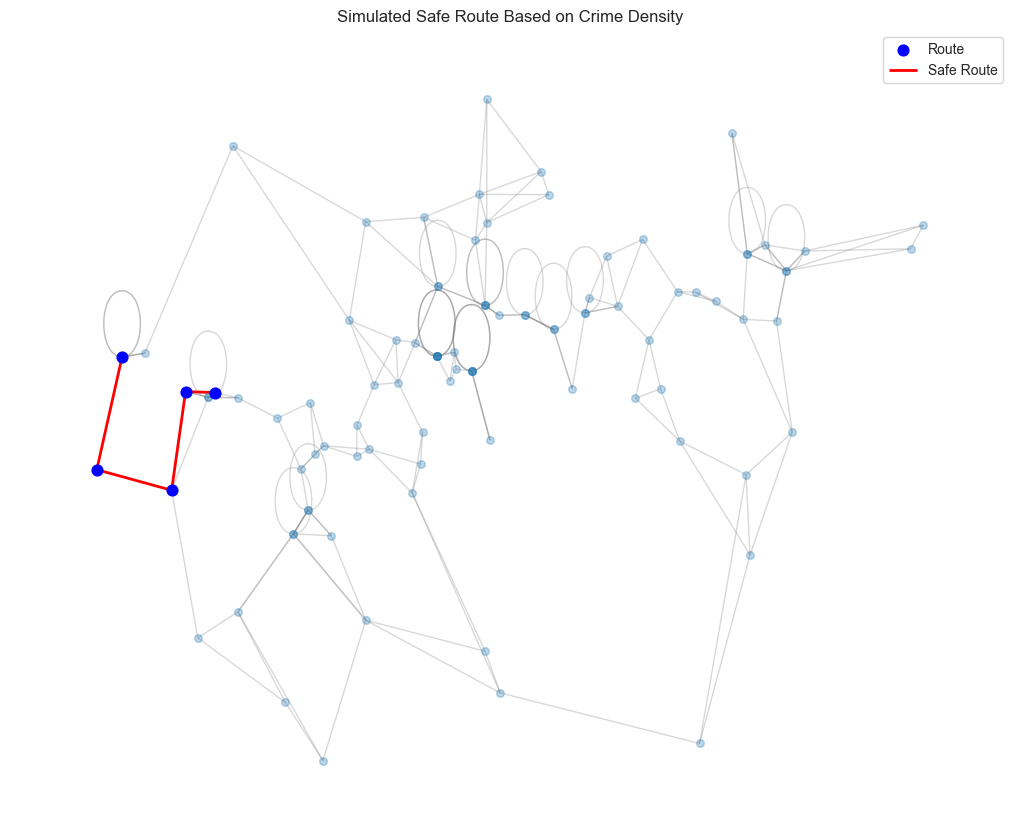

In [128]:
# Simulate street nodes (for demonstration, use random sample of crime locations as nodes)
nodes = coords.sample(100, random_state=42).reset_index(drop=True)
G = nx.Graph()
for i, row in nodes.iterrows():
        G.add_node(i, pos=(row['Latitude'], row['Longitude']))

# Connect nodes to nearest neighbors
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=4, algorithm='ball_tree').fit(nodes[['Latitude', 'Longitude']])
distances, indices = nbrs.kneighbors(nodes[['Latitude', 'Longitude']])
for i, neighbors in enumerate(indices):
        for j in neighbors[1:]:  # skip self
            G.add_edge(i, j)

# Estimate crime density at each node using KDE
kde = KernelDensity(bandwidth=0.01)
kde.fit(coords[['Latitude', 'Longitude']])
densities = np.exp(kde.score_samples(nodes[['Latitude', 'Longitude']]))

# Assign density as edge weights (average of node densities)
for u, v in G.edges():
        risk = (densities[u] + densities[v]) / 2
        G[u][v]['weight'] = risk

# Find a pair of connected nodes for the route simulation
connected = False
for source in G.nodes:
    for target in G.nodes:
        if source != target and nx.has_path(G, source, target):
            path = nx.shortest_path(G, source=source, target=target, weight='weight')
            connected = True
            break
    if connected:
        break

if not connected:
    print('No connected node pairs found in the graph.')
else:
    # Plot nodes, edges, and the safest path
    plt.figure(figsize=(10, 8))
    pos = {i: (row['Longitude'], row['Latitude']) for i, row in nodes.iterrows()}
    nx.draw(G, pos, node_size=30, edge_color='gray', alpha=0.3, with_labels=False)
    nx.draw_networkx_nodes(G, pos, nodelist=path, node_color='blue', node_size=60, label='Route')
    nx.draw_networkx_edges(G, pos, edgelist=list(zip(path, path[1:])), edge_color='red', width=2, label='Safe Route')
    plt.title('Simulated Safe Route Based on Crime Density')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.show()

### Route Safety Explanation

By modeling Bristol streets as a graph and using crime density as risk weights, the route planner can recommend paths that minimize exposure to high-risk areas. This approach helps travelers choose safer routes, especially during high-crime periods or in unfamiliar neighborhoods.